In [227]:
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import pandas as pd
import geopandas as gpd
import networkx as nx
from scipy.spatial.distance import cdist
import os

from citychef import spatial
from citychef import graph
from citychef import household as hh
from citychef import person
from citychef import tree
from citychef import choice
from citychef import osm, gtfs
from citychef.household import minmax

In [228]:
city_dir = "./festival_of_data/city_B"

In [229]:
if not os.path.exists(city_dir):
    os.mkdir(city_dir)
else:
    print("WARNING - potentially overwritting previous results")

WARNING - potentially overwritting previous results


In [230]:
# city A
# TARGET_HHS = 2000
# SEED_AREA = [[275000,780000],[277000,782000]]
# TARGET_CENTRES = 5
# BUS_ROUTES = 12
# TRAIN_ROUTES = 4

# city B
TARGET_HHS = 2000
SEED_AREA = [[278000,783000],[283000,788000]]
TARGET_CENTRES = 8
BUS_ROUTES = 8
TRAIN_ROUTES = 1

In [231]:
(x0, y0), (x1, y1) = SEED_AREA
area = (x1-x0) * (y1-y0)
centres = spatial.Centres(SEED_AREA, density = TARGET_CENTRES/area)

spread = ((x1-x0) + (y1-y1))/10
facilities = {
    'households': spatial.Clusters(centres, size=TARGET_HHS, sigma=spread).crop_to_bbox(SEED_AREA),
    'work': spatial.Clusters(centres, size=TARGET_HHS/10, sigma=spread/2).crop_to_bbox(SEED_AREA),
    'leisure': spatial.Clusters(centres, size=TARGET_HHS/20, sigma=spread/2).crop_to_bbox(SEED_AREA),
    'education': spatial.Clusters(centres, size=TARGET_HHS/20, sigma=spread/3).crop_to_bbox(SEED_AREA),
    'health': spatial.Clusters(centres, size=TARGET_HHS/50, sigma=spread/3).crop_to_bbox(SEED_AREA),
    'shopping': spatial.Clusters(centres, size=TARGET_HHS/20, sigma=spread/4).crop_to_bbox(SEED_AREA),
}
bbox = spatial.collect_bbox(facilities) # adjust the bbox for max extends

spatial.write_buildings_geojson(
    facilities,
    path=os.path.join(city_dir, "building_locations.geojson"),
    epsg="epsg:27700",
    to_epsg="epsg:4326"
    )

In [232]:
car_network = graph.TreeNetwork(bbox, facilities['households'], grid='regular', max_points=50, label="highway")

# osm.nx_to_osm(
#     g=car_network.g,
#     path=os.path.join(city_dir, "car_osm.xml")
# )
graph.nx_to_geojson(
    g=car_network.g,
    path=os.path.join(city_dir, "car_network.geojson"),
    epsg="epsg:27700",
    to_epsg="epsg:4326"
)
# fig.savefig(os.path.join(city_dir, 'road_network.png'))

In [233]:
buses = graph.Transit(car_network, facilities['households'], density_radius=1000)
bus_routes = buses.build_routes(num_routes=BUS_ROUTES, max_length=30, min_length=10, straightness=2)
total_bus_graph = buses.graph

gtfs.build_gtfs(
    transit=buses,
    name="bus",
    out_dir=city_dir,
    agency_id=0,
    agency_name='bus_connect',
    frequency=10,
    from_epsg="epsg:27700",
    to_epsg="epsg:4326"
)

graph.nx_to_geojson(
    g=buses.graph,
    path=os.path.join(city_dir, "bus_network.geojson"),
    epsg="epsg:27700",
    to_epsg="epsg:4326"
)

Output()

In [234]:
potential_stations = np.array([v['pos'] for k, v in car_network.g.nodes.items() if k[:2] == '00'])
rail_network = graph.DelaunayNetwork(potential_stations)

trains = graph.Transit(rail_network, facilities['households'])
train_routes = trains.build_routes(num_routes=TRAIN_ROUTES, max_length=12, min_length=10, straightness=20)

total_train_graph = trains.graph

gtfs.build_gtfs(
    transit=trains,
    name="rail",
    out_dir=city_dir,
    agency_id=1,
    agency_name='rail_get_you_there',
    frequency=30,
    from_epsg="epsg:27700",
    to_epsg="epsg:4326"
)

graph.nx_to_geojson(
    g=trains.graph,
    path=os.path.join(city_dir, "rail_network.geojson"),
    epsg="epsg:27700",
    to_epsg="epsg:4326"
)

Output()

/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


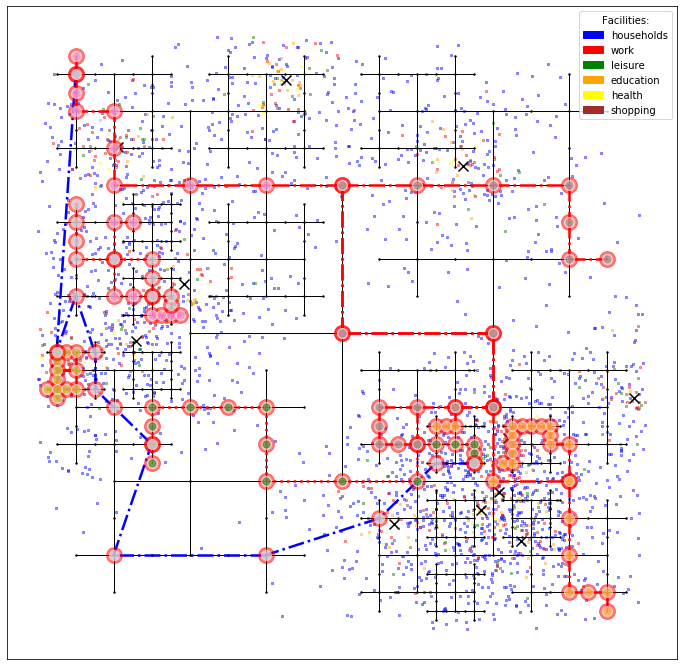

In [235]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
spatial.plot_facilities(facilities, centres=centres, ax=ax)
car_network.plot(ax=ax)
buses.plot(ax=ax)
trains.plot(ax=ax, line_colour='blue')
fig.patch.set_visible(False)
# ax.axis('off')
# plt.axis('equal')

# fig.savefig(os.path.join(city_dir, 'city.png'))

In [236]:
hh_df = pd.DataFrame(range(facilities['households'].size), columns=['hh_index'])
hh_hidden_df = pd.DataFrame(range(facilities['households'].size), columns=['hh_index'])

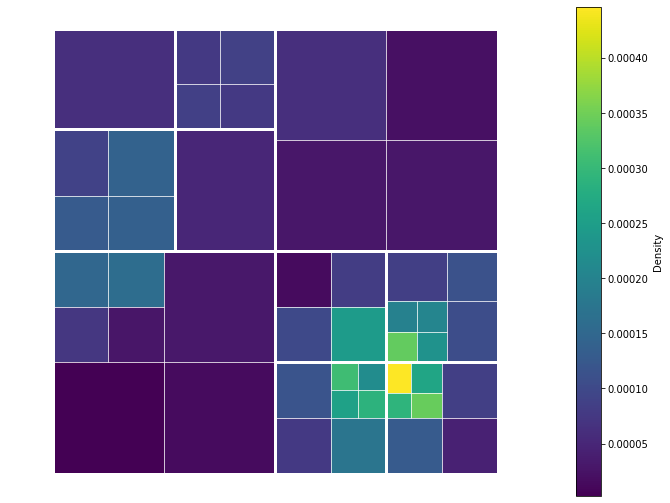

In [237]:
zones = tree.Zones(
    bbox=bbox, 
    facilities=facilities['households'],
    max_zone_facilities=400,
    max_sub_zone_facilities=100,
)
zones.plot()

zones.zone_gdf.crs = "EPSG:27700"
zones.zone_gdf.to_crs("epsg:4226").to_file(os.path.join(city_dir, "administrative_areas.geojson"), driver='GeoJSON')

zones.sub_zone_gdf.crs = "EPSG:27700"
zones.sub_zone_gdf.to_crs("epsg:4226").to_file(os.path.join(city_dir, "administrative_zones.geojson"), driver='GeoJSON')


In [238]:
# fig.savefig(os.path.join(city_dir, 'density.png'))

In [239]:
hhs = facilities['households']
work = facilities['work']
leisure = facilities['leisure']
education = facilities['education']
health = facilities['health']
shopping = facilities['shopping']

hh_dist_to_centre = hhs.dist_to_centres()
hh_dist_to_centre_mm = minmax(hh_dist_to_centre)

hh_df['area_id'] = zones.facility_zone_ids
hh_df['zone_id'] = zones.facility_sub_zone_ids

n = centres.size

hh_hidden_df['density_mm'] = spatial.density(hhs, hhs)
hh_hidden_df['dist_closest_centre_mm'] = spatial.distances_to_closest(hhs, centres, 1)
hh_hidden_df['dist_closest_centres_mm'] = spatial.distances_to_closest(hhs, centres, max([n,3]))
hh_hidden_df['density_work_places_mm'] = spatial.density(hhs, work, 500)
hh_hidden_df['density_leisure_mm'] = spatial.density(hhs, leisure, 500)
hh_hidden_df['dist_closest_schools_mm'] = spatial.distances_to_closest(hhs, education, max([n,2]))
hh_hidden_df['dist_closest_health_mm'] = spatial.density(hhs, health, 500)

hh_locs_mm = minmax(hhs.locs)
hh_centre_ids_mm = minmax(hhs.ids)

hh_hidden_df['hidden'] = hh.gen_hidden(hh_locs_mm[:,0], hh_locs_mm[:,1], hh_hidden_df['density_mm'])

/Users/fred.shone/Projects/citychef/citychef/spatial.py:309: RuntimeWarning: invalid value encountered in true_divide
  return (array - min(array)) / (max(array) - min(array))
/Users/fred.shone/Projects/citychef/citychef/household.py:26: RuntimeWarning: invalid value encountered in true_divide
  choice = choice/sum(choice)
/Users/fred.shone/Projects/citychef/citychef/household.py:27: RuntimeWarning: invalid value encountered in less
  return np.random.choice([1, 2, 3, 4, 5], p=choice)


In [240]:
hh_hidden_df.head(10)

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden
0,0,NaN,0.443261,0.370875,0.10,0.181818,0.324795,0.000000,1
1,1,NaN,0.048240,0.076744,0.98,0.863636,0.043173,0.933333,1
2,2,NaN,0.113461,0.240182,0.66,0.636364,0.117111,0.466667,1
3,3,NaN,0.332875,0.227630,0.40,0.409091,0.204973,0.200000,4
4,4,NaN,0.413595,0.577337,0.06,0.045455,0.371968,0.000000,4
5,5,NaN,0.132141,0.149925,0.88,0.863636,0.050563,0.733333,4
6,6,NaN,0.270605,0.026839,0.58,0.409091,0.206331,0.400000,5
7,7,NaN,0.450684,0.591024,0.06,0.000000,0.385662,0.000000,4
8,8,NaN,0.328482,0.005147,0.26,0.272727,0.345048,0.133333,1
9,9,NaN,0.126099,0.192528,0.38,0.272727,0.123720,0.133333,5


### Household Features

Household features are generated based on hidden features and previously generated features. All generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [241]:
hh_df['hh_count'] = hh.gen_hh_count(
    hh_hidden_df['hidden'], 
    hh_hidden_df['density_mm']
)

hh_df['hh_children'] = hh.gen_num_children(
    hh_df['hh_count'],
    hh_hidden_df['hidden'],
    hh_hidden_df['dist_closest_schools_mm'],
    hh_hidden_df['density_leisure_mm']
)

hh_hidden_df['age_group'] = hh.gen_age_group(
    hh_df['hh_children'],
    hh_hidden_df['hidden'],
    hh_hidden_df['density_mm']
)

hh_df['hh_people_in_work'] = hh.get_people_in_work(
    hh_hidden_df['age_group'],
    hh_hidden_df['hidden'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_mm']
)

hh_df['hh_in_work'] = hh.get_in_work(
    hh_df['hh_people_in_work']
)

hh_df['hh_income'] = hh.get_income(
    hh_df['hh_in_work'],
    hh_df['hh_count'],
    hh_df['hh_children'],
    hh_hidden_df['density_work_places_mm'],
    hh_hidden_df['density_mm']
)

hh_income_mm = minmax(hh_df['hh_income'])

hh_df['hh_cars'] = hh.get_cars(
    hh_hidden_df['hidden'],
    hh_income_mm,
    hh_hidden_df['density_mm'],
    hh_df['hh_count'],
    hh_df['hh_children']
)

/Users/fred.shone/Projects/citychef/citychef/household.py:42: RuntimeWarning: invalid value encountered in less
  return np.random.choice([1, 2, 3, 4, 5], p=choice)
/Users/fred.shone/Projects/citychef/citychef/household.py:80: RuntimeWarning: invalid value encountered in less
  p=(p_old, 1-p_old)


ValueError: p is nan

In [ ]:
hh_df.head()

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars
0,0,2.0,2.3,3,1,1,1,50000,0
1,1,3.0,3.1,3,1,1,1,75000,0
2,2,9.0,9.1,5,3,0,0,23000,1
3,3,9.0,9.1,2,0,1,1,35000,0
4,4,9.0,9.2,4,1,3,1,85000,3


### Individual Features

Individuals features are generated based on their household hidden features and previously generated features. As per for households, all generative funtions combine some level of probabalitic sampling. Data sampling is designed to generate non linear and complex dependancies. The aim of which is to create a population with complex and noisy interdependencies between features.

In [ ]:
# hh features
hh_counts = hh_df['hh_count'].to_numpy()
agent_hh_array = np.repeat(hh_df.to_numpy(), hh_counts, axis=0)
person_df = pd.DataFrame(agent_hh_array)
person_df.columns = hh_df.columns
person_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

#hidden vectors
agent_hidden_array = np.repeat(hh_hidden_df.to_numpy(), hh_counts, axis=0)
person_hidden_df = pd.DataFrame(agent_hidden_array)
person_hidden_df.columns = hh_hidden_df.columns
person_hidden_df['p_hh_index'] = np.array([i for c in hh_df['hh_count'] for i in range(c)])

In [ ]:
person_df['adult'] = person.get_is_adult(
    person_df['p_hh_index'],
    person_df['hh_count'],
    person_df['hh_children']
)

person_df['gender'] = person.get_gender(
    person_df['p_hh_index'], 
    person_df['adult'],
    person_df['hh_children'],
    person_hidden_df['hidden']
)

person_df['age'] = person.get_age(
    person_hidden_df['hidden'],
    person_hidden_df['age_group'],
    person_df['adult']
)

person_df['employment'] = person.employment(
    person_df['adult'],
    person_df['hh_people_in_work'],
    person_df['p_hh_index'],
    person_df['age'],
    person_hidden_df['hidden'],
    person_hidden_df['dist_closest_schools_mm'],
    person_hidden_df['density_work_places_mm'],
    person_df['hh_income'],
    person_hidden_df['density_mm'],
)

person_df['occupation'] = person.occupation(
    person_df['employment'],
    person_df['age'],
    minmax(person_df['hh_income']),
)

person_df.head(10)

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation
0,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,0,1,1,22.0,3,1
1,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,1,1,0,19.0,3,1
2,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,2,0,1,6.0,2,0
3,1.0,3.0,3.1,3.0,1.0,1.0,1.0,75000.0,0.0,0,1,1,22.0,3,1
4,1.0,3.0,3.1,3.0,1.0,1.0,1.0,75000.0,0.0,1,1,1,22.0,3,1
5,1.0,3.0,3.1,3.0,1.0,1.0,1.0,75000.0,0.0,2,0,0,12.0,2,0
6,2.0,9.0,9.1,5.0,3.0,0.0,0.0,23000.0,1.0,0,1,1,22.0,3,1
7,2.0,9.0,9.1,5.0,3.0,0.0,0.0,23000.0,1.0,1,1,0,22.0,3,1
8,2.0,9.0,9.1,5.0,3.0,0.0,0.0,23000.0,1.0,2,0,0,8.0,2,0
9,2.0,9.0,9.1,5.0,3.0,0.0,0.0,23000.0,1.0,3,0,1,9.0,2,0


In [ ]:
person_hidden_df.head(10)

,hh_index,density_mm,dist_closest_centre_mm,dist_closest_centres_mm,density_work_places_mm,density_leisure_mm,dist_closest_schools_mm,dist_closest_health_mm,hidden,age_group,p_hh_index
0,0.0,0.0,0.324359,0.054413,0.369048,0.638889,0.292767,0.666667,1.0,18.0,0
1,0.0,0.0,0.324359,0.054413,0.369048,0.638889,0.292767,0.666667,1.0,18.0,1
2,0.0,0.0,0.324359,0.054413,0.369048,0.638889,0.292767,0.666667,1.0,18.0,2
3,1.0,0.0,0.224389,0.124667,0.428571,0.638889,0.201346,0.600000,1.0,19.0,0
4,1.0,0.0,0.224389,0.124667,0.428571,0.638889,0.201346,0.600000,1.0,19.0,1
5,1.0,0.0,0.224389,0.124667,0.428571,0.638889,0.201346,0.600000,1.0,19.0,2
6,2.0,0.0,0.244266,0.106735,0.488095,0.638889,0.117110,0.533333,1.0,20.0,0
7,2.0,0.0,0.244266,0.106735,0.488095,0.638889,0.117110,0.533333,1.0,20.0,1
8,2.0,0.0,0.244266,0.106735,0.488095,0.638889,0.117110,0.533333,1.0,20.0,2
9,2.0,0.0,0.244266,0.106735,0.488095,0.638889,0.117110,0.533333,1.0,20.0,3


In [ ]:
print(len(person_df))
print(len(hh_df))

6728
1826


### Activity Choice

A simple activity plan is generated based on individual features. This plan consists of a single activity at a given facility location.

#### Method
1. Activity type choice is made based on household and individual features. This can include staying at home.
2. Facilities for each activity type are weighted by their desirability (based on density and distance).
3. Agents randomly choose a facility based on this weighting and on their individual features.

In [ ]:
# Main activity choice
person_df['main_activity'] = choice.main_activity_choice(
    person_df['employment'],
    person_hidden_df['density_work_places_mm'],
    person_df['occupation'],
    person_hidden_df['hidden'],
    minmax(person_df['hh_income']),
    person_df['hh_count'],
    person_hidden_df['dist_closest_centres_mm'],
    person_hidden_df['density_leisure_mm'],
    person_df['age'],
)

In [ ]:
person_df.head()

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,adult,gender,age,employment,occupation,main_activity
0,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,0,1,1,22.0,3,1,1
1,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,1,1,0,19.0,3,1,5
2,0.0,2.0,2.3,3.0,1.0,1.0,1.0,50000.0,0.0,2,0,1,6.0,2,0,2
3,1.0,3.0,3.1,3.0,1.0,1.0,1.0,75000.0,0.0,0,1,1,22.0,3,1,1
4,1.0,3.0,3.1,3.0,1.0,1.0,1.0,75000.0,0.0,1,1,1,22.0,3,1,1


In [ ]:
# FACILITY FEATURES
zone_gdf = zones.sub_zone_gdf

work_df = pd.DataFrame(range(work.size), columns=['index'])
work_df['density_mm'] = spatial.density(work, work, 500)
work_df['geometry'] = [Point(x,y) for x,y in work.locs]
work_gdf = gpd.GeoDataFrame(work_df, geometry='geometry')
work_gdf = gpd.sjoin(work_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

leisure_df = pd.DataFrame(range(leisure.size), columns=['index'])
leisure_df['density_mm'] = spatial.density(leisure, shopping, 500)
leisure_df['geometry'] = [Point(x,y) for x,y in leisure.locs]
leisure_gdf = gpd.GeoDataFrame(leisure_df, geometry='geometry')
leisure_gdf = gpd.sjoin(leisure_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

education_df = pd.DataFrame(range(education.size), columns=['index'])
education_df['density_mm'] = spatial.density(education, shopping, 500)
education_df['geometry'] = [Point(x,y) for x,y in education.locs]
education_gdf = gpd.GeoDataFrame(education_df, geometry='geometry')
education_gdf = gpd.sjoin(education_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

health_df = pd.DataFrame(range(health.size), columns=['index'])
health_df['density_mm'] = spatial.density(health, shopping, 500)
health_df['geometry'] = [Point(x,y) for x,y in health.locs]
health_gdf = gpd.GeoDataFrame(health_df, geometry='geometry')
health_gdf = gpd.sjoin(health_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)

shopping_df = pd.DataFrame(range(shopping.size), columns=['index'])
shopping_df['density_mm'] = spatial.density(shopping, shopping, 300)
shopping_df['geometry'] = [Point(x,y) for x,y in shopping.locs]
shopping_gdf = gpd.GeoDataFrame(shopping_df, geometry='geometry')
shopping_gdf = gpd.sjoin(shopping_gdf, zone_gdf, how="left", op='within').drop('index_right', axis=1)


/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:27700)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:27700)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:27700)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:27700)
  "(%s != %s)" % (left_df.crs, right_df.crs)
/Users/fred.shone/.ve/citychef/lib/python3.7/site-packages/geopandas/tools/sjoin.py:61: UserWarning: CRS of frames being joined does not match!(None != EPSG:27700)


In [ ]:
hhs_work_distances = minmax(cdist(hhs.locs, work.locs))
hhs_education_distances = minmax(cdist(hhs.locs, education.locs))
hhs_shopping_distances = minmax(cdist(hhs.locs, shopping.locs))
hhs_leisure_distances = minmax(cdist(hhs.locs, leisure.locs))
hhs_health_distances = minmax(cdist(hhs.locs, health.locs))

In [ ]:
main_facility_id = np.zeros((len(person_df)))
main_facility_area = np.zeros((len(person_df)))
main_facility_zone = np.zeros((len(person_df)))

for i, (hh_index, main_act, income_mm) in enumerate(zip(person_df.hh_index, person_df.main_activity, minmax(person_df['hh_income']))):
    
    if main_act == 0:  # home
        main_facility_id[i] = -1
        main_facility_area[i] = -1
        main_facility_zone[i] = -1
        
    hh_index = int(hh_index)
        
    if main_act == 1:  # work
        facility_distances = hhs_work_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * work_df.density_mm
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = work_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 2:  # education
        facility_distances = hhs_education_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 2
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = education_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 3:  # shopping
        facility_distances = hhs_shopping_distances[hh_index]
        facility_scores = (1 - income_mm) * (1 - facility_distances) + income_mm * shopping_df.density_mm
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = shopping_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 4:  # leisure
        facility_distances = hhs_leisure_distances[hh_index]
        facility_scores = (1 - facility_distances)
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = leisure_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue
        
    if main_act == 5:  # health
        facility_distances = hhs_health_distances[hh_index]
        facility_scores = (1 - facility_distances) ** 4
        facility_scores = facility_scores / facility_scores.sum()
        facitlity_id = np.random.choice(range(len(facility_scores)), p=facility_scores)
        main_facility_id[i] = facitlity_id
        main_facility_area[i], main_facility_zone[i] = health_gdf[['area_id', 'zone_id']].iloc[facitlity_id]
        continue

person_df['main_activity_id'] = main_facility_id
person_df['main_facility_area'] = main_facility_area
person_df['main_facility_zone'] = main_facility_zone


In [ ]:
# HH CAR CONNECTIVITY
car_ods = graph.NodesOD(car_network.g)

hh_df['car_dist'], hh_df['car_node'] = spatial.distance_index_nearest_node(hhs, car_network.locs)
work_df['car_dist'], work_df['car_node'] = spatial.distance_index_nearest_node(work, car_network.locs)
leisure_df['car_dist'], leisure_df['car_node'] = spatial.distance_index_nearest_node(leisure, car_network.locs)
education_df['car_dist'], education_df['car_node'] = spatial.distance_index_nearest_node(education, car_network.locs)
health_df['car_dist'], health_df['car_node'] = spatial.distance_index_nearest_node(health, car_network.locs)
shopping_df['car_dist'], shopping_df['car_node'] = spatial.distance_index_nearest_node(shopping, car_network.locs)

In [ ]:
hh_df.head()

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,car_dist,car_node
0,0,2.0,2.3,3,1,1,1,50000,0,45.512609,171
1,1,3.0,3.1,3,1,1,1,75000,0,43.025036,157
2,2,9.0,9.1,5,3,0,0,23000,1,48.870435,535
3,3,9.0,9.1,2,0,1,1,35000,0,79.092904,539
4,4,9.0,9.2,4,1,3,1,85000,3,58.305410,529


In [ ]:
# HH PT CONNECTIVITY
pt_network = nx.compose(total_bus_graph, total_train_graph)
pt_pos = {n:d['pos'] for n,d in pt_network.nodes(data=True)}
pt_node_locs = np.array([d['pos'] for n,d in pt_network.nodes(data=True)])
pt_ods = graph.NodesOD(pt_network)

In [ ]:
hh_df['pt_dist'], hh_df['pt_node'] = spatial.distance_index_nearest_node(hhs, pt_node_locs)
work_df['pt_dist'], work_df['pt_node'] = spatial.distance_index_nearest_node(work, pt_node_locs)
leisure_df['pt_dist'], leisure_df['pt_node'] = spatial.distance_index_nearest_node(leisure, pt_node_locs)
education_df['pt_dist'], education_df['pt_node'] = spatial.distance_index_nearest_node(education, pt_node_locs)
health_df['pt_dist'], health_df['pt_node'] = spatial.distance_index_nearest_node(health, pt_node_locs)
shopping_df['pt_dist'], shopping_df['pt_node'] = spatial.distance_index_nearest_node(shopping, pt_node_locs)

In [ ]:
hh_df.head()

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,car_dist,car_node,pt_dist,pt_node
0,0,2.0,2.3,3,1,1,1,50000,0,45.512609,171,65.990680,8
1,1,3.0,3.1,3,1,1,1,75000,0,43.025036,157,81.182667,11
2,2,9.0,9.1,5,3,0,0,23000,1,48.870435,535,167.901605,24
3,3,9.0,9.1,2,0,1,1,35000,0,79.092904,539,133.986423,27
4,4,9.0,9.2,4,1,3,1,85000,3,58.305410,529,58.305410,23


In [ ]:
car_time = np.zeros((len(person_df)))
pt_time = np.zeros((len(person_df)))
cycle_time = np.zeros((len(person_df)))
walk_time = np.zeros((len(person_df)))
mode_choice = np.zeros((len(person_df)))
journey_time = np.zeros((len(person_df)))

for i, (hh_index, main_act, main_id, income_mm, age_mm, adult, children, cars) in enumerate(
    zip(
        person_df.hh_index,
        person_df.main_activity,
        person_df.main_activity_id,
        minmax(person_df.hh_income),
        minmax(person_df.age),
        person_df.adult,
        person_df.hh_children,
        person_df.hh_cars,
              )):
    
    if main_act == 0:  # home
        mode_choice[i] = -1
        continue
        
    main_id = int(main_id)
    hh_index = int(hh_index)
    
    hh_loc = hhs.locs[hh_index]
    
    hh_car_node_dist, hh_car_node = hh_df.car_dist[hh_index], hh_df.car_node[hh_index]
    hh_car_node_time = 1.4 * 3600 * hh_car_node_dist / 25
    
    hh_pt_node_dist, hh_pt_node = hh_df.pt_dist[hh_index], hh_df.pt_node[hh_index]
    hh_pt_node_time = 3600 * hh_car_node_dist / 5
    
    times = {}
    options = {}
        
    if main_act == 1:  # work
        
        facility_loc = work.locs[main_id]
        facility_df = work_df
        
    if main_act == 2:  # education
        
        facility_loc = education.locs[main_id]
        facility_df = education_df
        
    if main_act == 3:  # shopping
        
        facility_loc = shopping.locs[main_id]
        facility_df = shopping_df
        
    if main_act == 4:  # leisure
        
        facility_loc = leisure.locs[main_id]
        facility_df = leisure_df
        
    if main_act == 5:  # health
        
        facility_loc = health.locs[main_id]
        facility_df = health_df
     
    # choice
    eucl_distance = ((hh_loc - facility_loc)**2).sum()**.5
    manh_distance = np.abs(hh_loc - facility_loc).sum()
    
    # car
    facility_car_node_dist, facility_car_node = facility_df.car_dist[main_id], facility_df.car_node[main_id]
    car_network_travel = car_ods.get(hh_car_node, facility_car_node)
    if car_network_travel != -1:
        facility_car_node_time = 1.4 * 3600 * facility_car_node_dist / 25
        car_journey_time = hh_car_node_time + facility_car_node_time + car_network_travel + 300
        if car_journey_time > 300:
            car_time[i] = car_journey_time
            times[0] = car_journey_time

            if not cars:
                options[0] =  3 / car_journey_time
            else:
                options[0] = 1 / car_journey_time * (1.1 - cars / 10) * (1 - children / 10)
    
    # pt
    facility_pt_node_dist, facility_pt_node = facility_df.pt_dist[main_id], facility_df.pt_node[main_id]
    pt_network_travel = pt_ods.get(hh_pt_node, facility_pt_node)
    if pt_network_travel != -1:
        facility_pt_node_time = 3600 * facility_pt_node_dist / 5
        pt_journey_time = hh_pt_node_time + facility_pt_node_time + pt_network_travel + 120
        if pt_journey_time > 300:
            pt_time[i] = pt_journey_time
            times[1] = pt_journey_time

            options[1] = 1/ pt_journey_time * (1 + age_mm / 100) * (1 + income_mm / 10)
    
    # cycle
    cycle_journey_time = 360 * manh_distance / 15 + 120
    if (cycle_journey_time < 3600) and (cycle_journey_time > 120):
        cycle_time[i] = cycle_journey_time
        times[2] = cycle_journey_time
        
        if main_act == 3:
            options[2] = 1/cycle_journey_time * 3
        else:
            options[2] = 1/cycle_journey_time * (1 + age_mm / 10) * (1 + income_mm / 10)

    # walk
    walk_journey_time = 360 * eucl_distance / 5
    if walk_journey_time < 3600:
        walk_time[i] = walk_journey_time
        times[3] = walk_journey_time
        options[3] = 1/walk_journey_time
    
    weights = np.array(list(options.values()))
    weights = weights / weights.sum()
    mode = np.random.choice(list(options), p=weights)
    time = times[mode]
    
    mode_choice[i] = mode
    journey_time[i] = time


In [ ]:
person_df['mode'] = mode_choice
person_hidden_df['journey_time'] = journey_time

In [ ]:
header = {
    'hh_in_work': {
        0: 'noone',
        1: 'yes',
    },
    'adult': {
        0: 'under16',
        1: '16+',
    },
    'gender': {
        0: 'male',
        1: 'female',
        2: 'other',
    },
    'employment': {
        0: 'retired',
        1: 'unemployed',
        2: 'education',
        3: 'employment',
    },
    'occupation': {
        0: 'none',
        1: 'unskilled',
        2: 'skilled',
        3: 'manager',
    },
    'main_activity': {
        0: 'None',
        1: 'work',
        2: 'education',
        3: 'shopping',
        4: 'leisure',
        5: 'health',
    },
    'mode': {
        0: 'car',
        1: 'PT',
        2: 'cycle',
        3: 'walk',
    },
    'hh_income_bin': {
        0: 'low',
        1: 'mid',
        2: 'mid-high',
        3: 'high',
    },
    'age_bin': {
        0: '-4',
        4: '4-13',
        13: '13-16',
        16: '16-21',
        21: '21-31',
        31: '31-41',
        41: '41-51',
        51: '51-61',
        61: '61-71',
        71: '71-81',
        81: '81+',
    }
}

In [ ]:
# import json
# with open(os.path.join(city_dir, 'header.json'), 'w') as f:
#     json.dump(header, f)

In [ ]:
person_df.columns

Index(['hh_index', 'area_id', 'zone_id', 'hh_count', 'hh_children',
       'hh_people_in_work', 'hh_in_work', 'hh_income', 'hh_cars', 'p_hh_index',
       'adult', 'gender', 'age', 'employment', 'occupation', 'main_activity',
       'main_activity_id', 'main_facility_area', 'main_facility_zone', 'mode'],
      dtype='object')

In [ ]:
# bin the continuous variables (income and age)
d = person_df.hh_income.describe()
bins = [0, d['25%'], d['50%'], d['75%'], d['max']]
labels = [0,1,2,3]
person_df['hh_income_bin'] = pd.cut(person_df.hh_income, bins=bins, labels=labels)

bins = [-1, 4, 13, 16, 21, 31, 41, 51, 61, 71, 81, 120]
labels = ['0-4', '4-13', '13-16','16-21', '21-31', '31-41', '41-51', '51-61', '61-71', '71-81', '81+']
# labels = [0, 4, 13, 16, 21, 31, 41, 51, 61, 71, 81]
person_df['age_bin'] = pd.cut(person_df.age, bins=bins, labels=labels)

person_df.hh_in_work = person_df.hh_in_work.map(header["hh_in_work"])
person_df.adult = person_df.adult.map(header["adult"])
person_df.gender = person_df.gender.map(header["gender"])
person_df.employment = person_df.employment.map(header["employment"])
person_df.occupation = person_df.occupation.map(header["occupation"])
person_df.main_activity = person_df.main_activity.map(header["main_activity"])
person_df["mode"] = person_df["mode"].map(header["mode"])
person_df.hh_income_bin = person_df.hh_income_bin.map(header["hh_income_bin"])

person_df.head()

,hh_index,area_id,zone_id,hh_count,hh_children,hh_people_in_work,hh_in_work,hh_income,hh_cars,p_hh_index,...,age,employment,occupation,main_activity,main_activity_id,main_facility_area,main_facility_zone,mode,hh_income_bin,age_bin
0,0.0,2.0,2.3,3.0,1.0,1.0,yes,50000.0,0.0,0,...,22.0,employment,unskilled,work,204.0,0.0,0.1,car,mid,21-31
1,0.0,2.0,2.3,3.0,1.0,1.0,yes,50000.0,0.0,1,...,19.0,employment,unskilled,health,6.0,10.0,10.3,car,mid,16-21
2,0.0,2.0,2.3,3.0,1.0,1.0,yes,50000.0,0.0,2,...,6.0,education,none,education,7.0,10.0,10.0,car,mid,4-13
3,1.0,3.0,3.1,3.0,1.0,1.0,yes,75000.0,0.0,0,...,22.0,employment,unskilled,work,64.0,5.0,5.4,car,mid-high,21-31
4,1.0,3.0,3.1,3.0,1.0,1.0,yes,75000.0,0.0,1,...,22.0,employment,unskilled,work,8.0,10.0,10.3,car,mid-high,21-31


#### Commuter Survey Output

We extract tours for work and education activities and create an zone based origin - destination freq table.

Note that we could further break-down by activity type and or mode choice.

In [ ]:
activities = ["work", "education"] # work & education
commuter_df = person_df.hh_index.loc[person_df.main_activity.isin(activities)]
commuter_freq_df = commuter_df.groupby([person_df.zone_id, person_df.main_facility_zone]).count()
commuter_freq_df.name = 'freq'
commuter_freq_df.to_csv(os.path.join(city_dir, 'zone_commuter_freq_table.csv'), header=True)

In [ ]:
# matrix version
commuter_freq_df.unstack().to_csv(os.path.join(city_dir, 'zone_commuter_freq_matrix.csv'), header=True)

In [ ]:
person_df.to_csv(os.path.join(city_dir, 'population_survey.csv'), header=True)

In [ ]:
person_df["mode"].value_counts()

car      5510
PT        144
cycle      72
walk        4
Name: mode, dtype: int64

In [ ]:
for c in person_df.columns:
    print("===>",c)
    if len(person_df[c].value_counts())<12:
        print(person_df[c].value_counts())

===> hh_index
===> area_id
===> zone_id
===> hh_count
5.0    3115
4.0    1876
3.0    1152
2.0     470
1.0     115
Name: hh_count, dtype: int64
===> hh_children
1.0    2512
0.0    2314
2.0    1438
3.0     414
4.0      50
Name: hh_children, dtype: int64
===> hh_people_in_work
2.0    2088
3.0    1618
1.0    1613
0.0     730
4.0     654
5.0      25
Name: hh_people_in_work, dtype: int64
===> hh_in_work
yes      5998
noone     730
Name: hh_in_work, dtype: int64
===> hh_income
===> hh_cars
1.0    2518
2.0    1822
0.0    1507
3.0     761
4.0      95
5.0      25
Name: hh_cars, dtype: int64
===> p_hh_index
0    1826
1    1711
2    1476
3    1092
4     623
Name: p_hh_index, dtype: int64
===> adult
16+        5150
under16    1578
Name: adult, dtype: int64
===> gender
male      3594
female    2988
other      146
Name: gender, dtype: int64
===> age
===> employment
employment    3569
education     1888
retired       1064
unemployed     207
Name: employment, dtype: int64
===> occupation
none         3